In [1607]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset

## Loading and Normalizing the data 

In [1608]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


## Visualisation of the data

In [1609]:
# Shape of image
img, label = training_data[0]
img.size()

torch.Size([3, 32, 32])

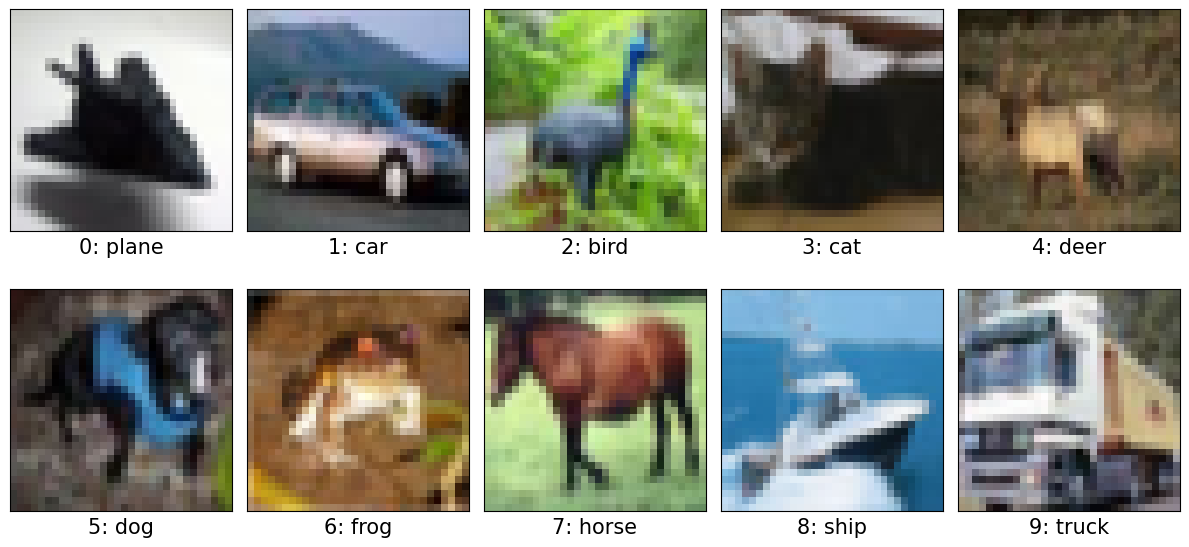

In [1610]:
# Visualize one training image per class
sample_images = [training_data.data[np.asarray(training_data.targets) == label][0] for label in range(10)]

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, axis in enumerate(axes.flat):
    axis.set_xlabel(f"{i}: {classes[i]}", fontsize=15)
    axis.imshow(sample_images[i])
    axis.set_xticks([])
    axis.set_yticks([])  

plt.tight_layout()
plt.show()


In [1611]:
# Prints stats for a given dataset
def print_stats(dataset, class_names):
    label_counts = {}
    total = 0

    if isinstance(dataset, Subset):
        # for subset
        targets = dataset.dataset.targets
        indices = dataset.indices
    else:
        # Full dataset
        targets = dataset.targets
        indices = range(len(dataset))

    for idx in indices:
        label = targets[idx]
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1
        total += 1

    print(f"Total images: {total}")
    for label in sorted(label_counts):
        print(f"Label {label} ({class_names[label]}): {label_counts[label]}")

In [1612]:
print("Traning data")
print_stats(training_data, classes)
print("\n")
print("Test data")
print_stats(test_data, classes)

Traning data
Total images: 50000
Label 0 (plane): 5000
Label 1 (car): 5000
Label 2 (bird): 5000
Label 3 (cat): 5000
Label 4 (deer): 5000
Label 5 (dog): 5000
Label 6 (frog): 5000
Label 7 (horse): 5000
Label 8 (ship): 5000
Label 9 (truck): 5000


Test data
Total images: 10000
Label 0 (plane): 1000
Label 1 (car): 1000
Label 2 (bird): 1000
Label 3 (cat): 1000
Label 4 (deer): 1000
Label 5 (dog): 1000
Label 6 (frog): 1000
Label 7 (horse): 1000
Label 8 (ship): 1000
Label 9 (truck): 1000


## Building the Traningdataset

In [1613]:
class FrogBinaryDataset(Dataset):
    def __init__(self, subset):
        self.subset = subset 

    def __getitem__(self, idx):
        data, label = self.subset[idx]
        # Convert to binary: 1 if frog (label 6), else 0
        if label == 6:
            binary_label = 1
        else:
            binary_label = 0
        return data, binary_label

    def __len__(self):
        return len(self.subset)

In [1614]:
print("Traning data")
print_stats(training_data, classes)

Traning data
Total images: 50000
Label 0 (plane): 5000
Label 1 (car): 5000
Label 2 (bird): 5000
Label 3 (cat): 5000
Label 4 (deer): 5000
Label 5 (dog): 5000
Label 6 (frog): 5000
Label 7 (horse): 5000
Label 8 (ship): 5000
Label 9 (truck): 5000


In [1615]:
# Convert to binary values 1 for frogs and o for other classes
binary_trainset = FrogBinaryDataset(training_data)

# Put into dataloader
trainloader = DataLoader(binary_trainset, batch_size=64, shuffle=True)

## Building the Test and Validationdataset

In [1616]:
print_stats(test_data, classes)

Total images: 10000
Label 0 (plane): 1000
Label 1 (car): 1000
Label 2 (bird): 1000
Label 3 (cat): 1000
Label 4 (deer): 1000
Label 5 (dog): 1000
Label 6 (frog): 1000
Label 7 (horse): 1000
Label 8 (ship): 1000
Label 9 (truck): 1000


In [1617]:
# Convert to binary values 1 for frogs and 0 for other classes
binary_testset = FrogBinaryDataset(test_data)
# Calculate lengths for the split
total_size = len(binary_testset)
split_size = int(total_size * 0.2)

test_subset = Subset(binary_testset, range(split_size))
val_subset = Subset(binary_testset, range(split_size, total_size))


In [1618]:
# Wrap in DataLoaders
testloader = DataLoader(test_subset, batch_size=64, shuffle=True)
valloader = DataLoader(val_subset, batch_size=64, shuffle=True)

## Convolutional Neural Network

In [1619]:
class FrogClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv_layer1 = nn.Conv2d(3, 12, kernel_size=5)

        self.bn1 = nn.BatchNorm2d(12)
        
        self.pool = nn.MaxPool2d(2, 2)                      
        
        self.conv_layer2 = nn.Conv2d(12, 24, kernel_size=5) 
        self.bn2 = nn.BatchNorm2d(24)
        
        # Fully connected layers
        self.fully_connected1 = nn.Linear(24 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.dropout1_fc = nn.Dropout(p=0.2)
        
        self.fully_connected2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.dropout2_fc = nn.Dropout(p=0.2)  
        
        self.fully_connected3 = nn.Linear(84, 2)

    def forward(self, data):
        data = self.pool(F.relu(self.bn1(self.conv_layer1(data))))
        data = self.pool(F.relu(self.bn2(self.conv_layer2(data))))
        
        data = torch.flatten(data, 1)
        
        data = F.relu(self.bn3(self.fully_connected1(data)))
        data = self.dropout1_fc(data)
        
        data = F.relu(self.bn4(self.fully_connected2(data)))
        data = self.dropout2_fc(data)
        
        data = self.fully_connected3(data)
        
        return data


In [1620]:
# defining an optimizer and lossfucntion
neural_network = FrogClassifier()
loss_function = nn.CrossEntropyLoss()
optimizer = SGD(neural_network.parameters(), lr=0.001, momentum=0.9)


## Traning The Model

In [1621]:
list_of_train_loss = []
list_of_val_loss = []
epochs = range(5)

for epoch in epochs:
    print(f"\nEpoch {epoch} / {max(epochs)}")
    
    # Traning 
    neural_network.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = neural_network(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(trainloader)
    list_of_train_loss.append(avg_train_loss)
    print(f"Train Loss: {avg_train_loss:.4f}")

    neural_network.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    # Validation
    with torch.no_grad():
        for val_inputs, val_labels in valloader:
            outputs = neural_network(val_inputs)
            loss = loss_function(outputs, val_labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    avg_val_loss = val_loss / len(valloader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    list_of_val_loss.append(avg_val_loss)




Epoch 0 / 4
Train Loss: 0.2392
Validation Loss: 0.1895

Epoch 1 / 4
Train Loss: 0.1765
Validation Loss: 0.2074

Epoch 2 / 4
Train Loss: 0.1601
Validation Loss: 0.1589

Epoch 3 / 4
Train Loss: 0.1477
Validation Loss: 0.1440

Epoch 4 / 4
Train Loss: 0.1396
Validation Loss: 0.1768


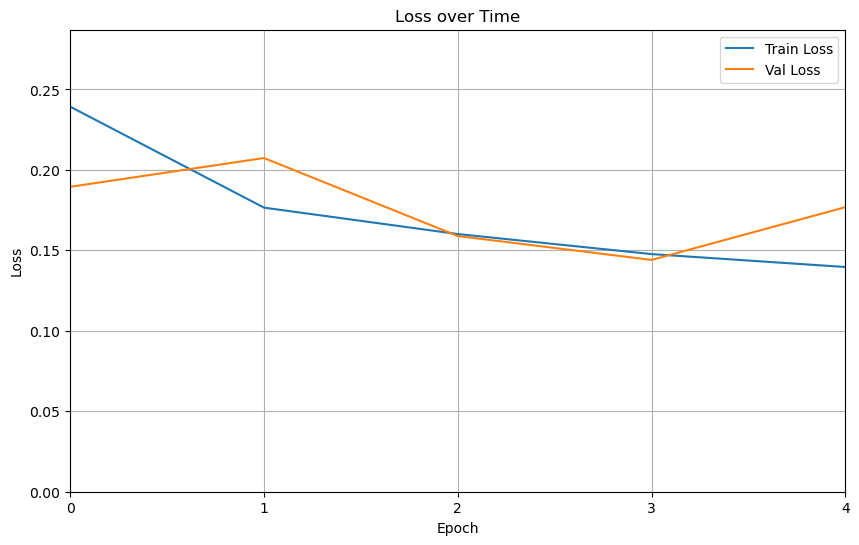

In [1622]:
# Plotting
fig, graph = plt.subplots(figsize=(10, 6))

# Plot average losses per epoch
graph.plot(list(epochs), list_of_train_loss, label='Train Loss', color='tab:blue')
graph.plot(list(epochs), list_of_val_loss, label='Val Loss', color='tab:orange')

# Axis limits and labels
graph.set_ylim(0, max(list_of_val_loss + list_of_train_loss) * 1.2)
graph.set_xlim(min(epochs), max(epochs))
graph.set_xticks(epochs) 
graph.legend()
plt.title("Loss over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [1623]:
# Save the model
PATH = './cifar_net.pth'
torch.save(neural_network.state_dict(), PATH)

## Evaluation

In [1624]:
network = neural_network
network.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [1625]:
# set model to eval mode
neural_network.eval()

FrogClassifier(
  (conv_layer1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected1): Linear(in_features=600, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1_fc): Dropout(p=0.2, inplace=False)
  (fully_connected2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_fc): Dropout(p=0.2, inplace=False)
  (fully_connected3): Linear(in_features=84, out_features=2, bias=True)
)

In [1626]:
correct = 0
recall = 0
total = 0

true_positive = 0
false_negative = 0

with torch.no_grad():
    for val_inputs, val_labels in valloader:
        outputs = neural_network(val_inputs)
        loss = loss_function(outputs, val_labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

        # For recall calculation (frog = 1)
        true_positive += ((predicted == 1) & (val_labels == 1)).sum().item()
        false_negative += ((predicted == 0) & (val_labels == 1)).sum().item()

val_accuracy = 100 * correct / total
recall = true_positive / (true_positive + false_negative + 1e-8)  

print(f"Accuracy: {val_accuracy:.2f}% | Recall (frog): {recall:.4f}")


Accuracy: 92.26% | Recall (frog): 0.7972
